### Imports

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

### Data Loading

In [16]:
X = []
Y = []
sizes = []

#url = 'https://www.dropbox.com/scl/fi/xl6leojssqiz12a6g6e35/Atlanta_supply_dat.xlsx-UC_buildings.csv?rlkey=9t4h432b0d5160kivwut4wwyy&dl=1'
#df = pd.read_csv(url)
df = pd.read_csv('Atlanta_Supply.csv')

size_dict = {}
for index, row in df.iterrows():
    size_dict[row['PropertyID']] = row['Size_sf']

for folder in range(0, 5):
    folder_path = os.path.join('labeled_data', str(folder))
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            file_path = os.path.join(folder_path, filename)
            with Image.open(file_path) as img:
                img = img.convert('RGB')
                img = img.resize((128, 128))
                img_array = np.array(img)

                id = filename.removesuffix('_goog.jpg').removesuffix('_bing.jpg').removesuffix('.png')
                X.append(img_array)
                Y.append(int(folder))
                sizes.append(size_dict[int(id)])

X = np.array(X)
Y = np.array(Y)

print(X[0])

mean = np.mean(X)
std = np.std(X)

X = (X - mean) / std

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

[[[ 68  64  90]
  [ 65  62  93]
  [ 75  71 102]
  ...
  [ 93  84 105]
  [ 98  89 108]
  [ 94  87 110]]

 [[ 61  59  85]
  [ 75  71  98]
  [ 85  79 107]
  ...
  [ 90  80 102]
  [ 98  90 107]
  [ 91  82 103]]

 [[ 82  76 100]
  [ 75  70  95]
  [ 78  72  99]
  ...
  [100  91 113]
  [ 95  87 107]
  [ 83  74  94]]

 ...

 [[120 105 115]
  [160 147 155]
  [139 127 134]
  ...
  [105  93 103]
  [197 187 188]
  [137 126 131]]

 [[150 137 146]
  [155 143 152]
  [124 105 116]
  ...
  [116 106 114]
  [196 186 187]
  [120 108 117]]

 [[158 146 156]
  [123 107 117]
  [115  98 108]
  ...
  [ 98  91 100]
  [193 184 187]
  [127 115 125]]]


### Classes

In [26]:
class longlabels(Dataset):
    def __init__(self, images, labels):
        self.X = images
        self.Y = labels
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.Y[idx]
        return torch.tensor(image, dtype=torch.float32).permute(2, 0, 1), torch.tensor(label, dtype=torch.long)



class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(16 * 16 * 64, 128) 
        self.fc2 = nn.Linear(128,64) 
        self.fc3 = nn.Linear(64,32) 
        self.fc4 = nn.Linear(32, 5) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### Train Model

In [40]:
train_dataset = longlabels(X_train, Y_train)
test_dataset = longlabels(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

model = ConvNet1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/30], Train Loss: 1.4250, Test Accuracy: 48.89%
Epoch [2/30], Train Loss: 1.1303, Test Accuracy: 53.33%
Epoch [3/30], Train Loss: 0.8856, Test Accuracy: 64.44%
Epoch [4/30], Train Loss: 0.7864, Test Accuracy: 71.11%
Epoch [5/30], Train Loss: 0.5945, Test Accuracy: 64.44%
Epoch [6/30], Train Loss: 0.5423, Test Accuracy: 71.11%
Epoch [7/30], Train Loss: 0.3103, Test Accuracy: 71.11%
Epoch [8/30], Train Loss: 0.3524, Test Accuracy: 75.56%
Epoch [9/30], Train Loss: 0.2683, Test Accuracy: 75.56%
Epoch [10/30], Train Loss: 0.1201, Test Accuracy: 71.11%
Epoch [11/30], Train Loss: 0.0826, Test Accuracy: 71.11%
Epoch [12/30], Train Loss: 0.0854, Test Accuracy: 75.56%
Epoch [13/30], Train Loss: 0.1398, Test Accuracy: 77.78%
Epoch [14/30], Train Loss: 0.0831, Test Accuracy: 66.67%
Epoch [15/30], Train Loss: 0.0194, Test Accuracy: 80.00%
Epoch [16/30], Train Loss: 0.0142, Test Accuracy: 68.89%
Epoch [17/30], Train Loss: 0.0423, Test Accuracy: 84.44%
Epoch [18/30], Train Loss: 0.0100, Test 

### Check Work (Ignore)

In [28]:
train_dataset = longlabels(X_train, Y_train)
test_dataset = longlabels(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

model = ConvNet1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()


all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm)


[[ 9  1  0  1  0]
 [ 1 13  0  0  1]
 [ 0  0  0  0  2]
 [ 1  0  2  3  0]
 [ 0  0  0  0 11]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

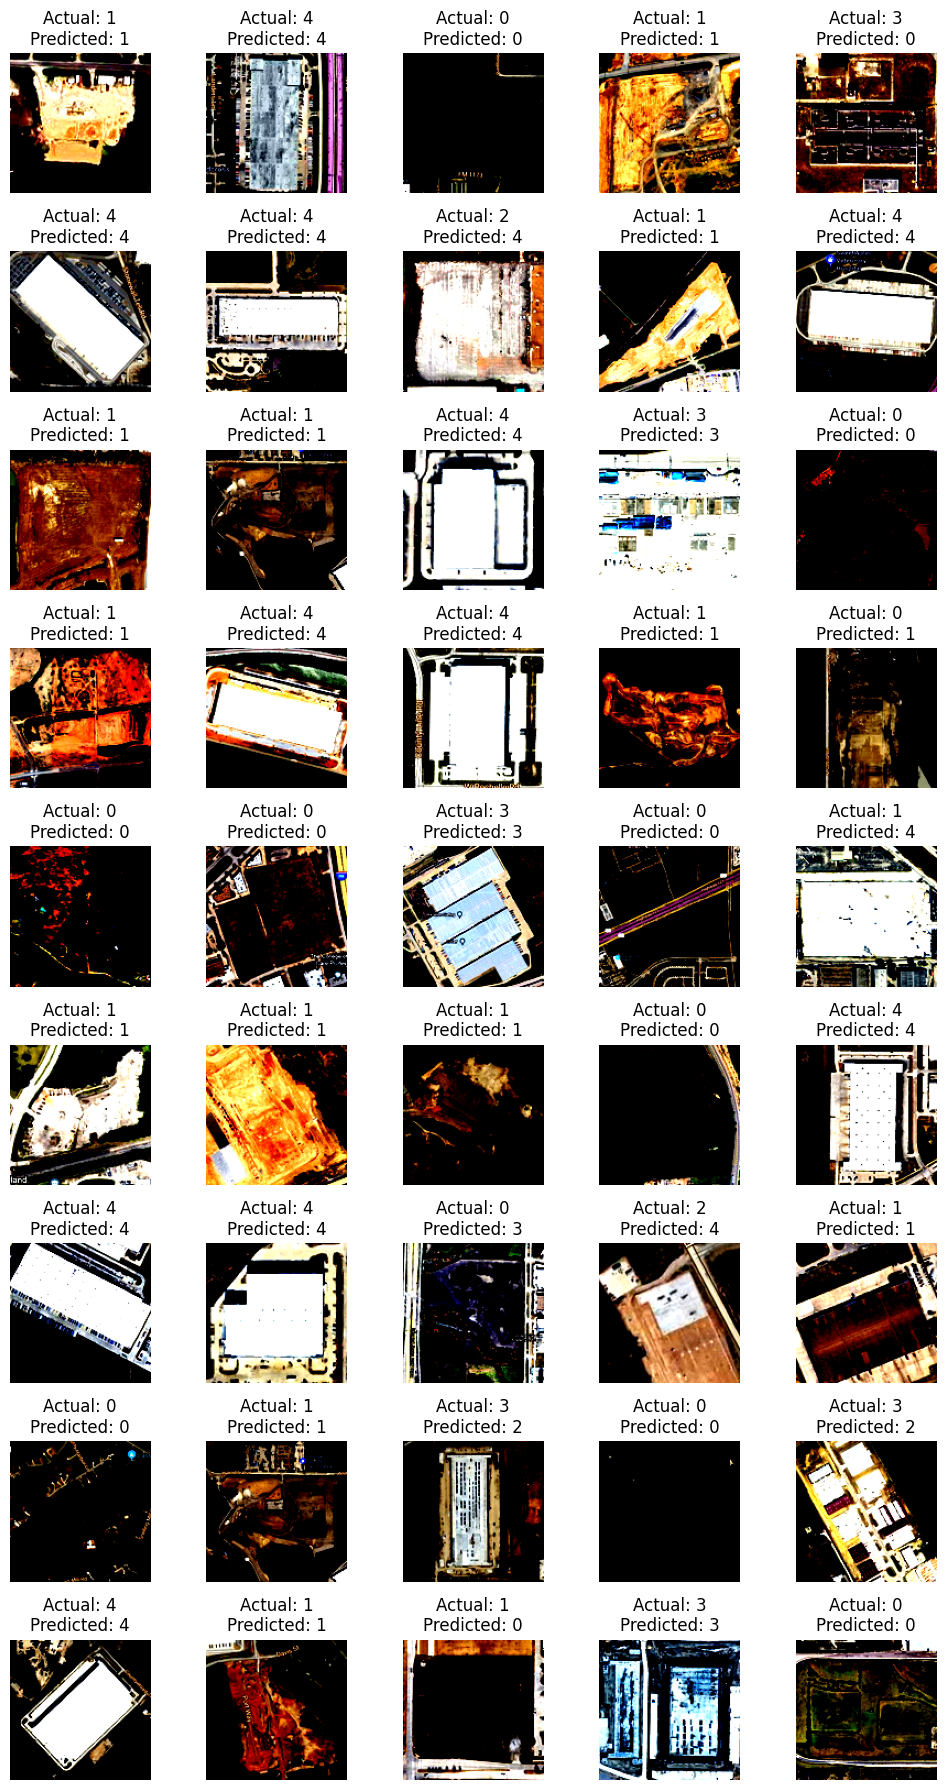

In [29]:
all_images = []
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_images.extend(images.cpu()) 
        all_labels.extend(labels.cpu().numpy()) 
        all_preds.extend(predicted.cpu().numpy()) 

def plot_images(images, true_labels, pred_labels):

    num_images = len(images)

    num_cols = 5
    num_rows = num_images // num_cols + (num_images % num_cols > 0) 

    plt.figure(figsize=(2 * num_cols, 2 * num_rows)) 

    for idx in range(num_images):
        plt.subplot(num_rows, num_cols, idx + 1)
        img = images[idx].permute(1, 2, 0) 
        plt.imshow(img, cmap='gray') if img.shape[2] == 1 else plt.imshow(img)
        plt.title(f'Actual: {true_labels[idx]}\nPredicted: {pred_labels[idx]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(all_images, all_labels, all_preds)

### Final Model Pipeline

In [139]:
def get_time_left(stage,size):
    multiplier = 0
    quarters = 0

    match stage:
        case 0:
            multiplier = 0
        case 1:
            multiplier = 0.25
        case 2:
            multiplier = 0.45
        case 3:
            multiplier = 0.85
        case 4:
            multiplier = 1
    
    if size <= 99999:
        quarters = 2
    elif size <= 299999:
        quarters = 3
    elif size <= 599999:
        quarters = 4
    elif size <= 999999:
        quarters = 5
    else:
        quarters = 6

    return (1-multiplier) * quarters

def process_image(image_path):
    image = Image.open(image_path)
    image = image.convert('RGB').resize((128, 128))
    image = (np.array(image) - mean) / std
    image_tensor = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0)
    return image_tensor

def predict(image_tensor):
    with torch.no_grad(): 
        output = model(image_tensor)
        _, predicted = torch.max(output, 1) 
    return predicted.item()

def run_prediction(image_path,df_info):
    image_tensor = process_image(image_path)
    stage_prediction = predict(image_tensor)
    # remove everything till the last slash
    img_id = int(''.join(list(image_path.split('/')[-1])[:10]))
    time_left_prediction = get_time_left(stage_prediction,df.loc[df['PropertyID'] == img_id, 'Size_sf'].values[0])
    print(f'Stage Prediction: {stage_prediction} | Time Left Prediction: {time_left_prediction} quarters')

# image path MUST contain property ID and must be in the form */{propertyID}*.jpg
# df is the dataframe containing the information about the properties, we need this to get the size of the property
run_prediction('labeled_data/0/1652880652_bing.jpg',df)

Stage Prediction: 0 | Time Left Prediction: 2 quarters
